## Table of contents
- [Load and view Raw Data](#load-data)
    - [Dataset characteristics](data-characteristics)
    - [correlation with target](#data-corr)
- [Data visualization](#Data-visualization)
- [Data preprocessing](#data-prep)
    - Feature engineering and one hot encoding
    - Save preprocessed data
- [Model Training](#model-train)
    - [Train and test loaders](#loaders)
    - [Model architecture selection ](#model-architecture-sel)
    - [Final model training](#save-final-w)
    - [Save final weights without overfitting](#final-model)

- [Inferences](#inferences)


- all data preprocessing and data loading in [dataset module](src/dataset.py)
- all train and testing in [model_trainning module](src/model_training.py.py)
- model architecture in [model module](src/model.py)

___

In [28]:

import torch
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from src import model_training, dataset, model, visualization
from torch.utils.data import DataLoader
from IPython.core.display_functions import display
import matplotlib.pyplot as plt



In [2]:
target_label_name = 'cnt'
raw_dataset_path = '../dataset/raw'
prep_dataset_path = '../dataset/preprocessed'


# Load and view raw Data <a name="load-data" />

In [9]:
raw_data_set_path = "../dataset/raw/bike-sharing-patterns.csv"


In [10]:
raw_data_df = pd.read_csv(raw_data_set_path)

In [11]:
raw_data_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [12]:
raw_data_df.describe().loc[['min', 'max', ]].iloc[:, 1:9]

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit
min,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
max,4.0,1.0,12.0,23.0,1.0,6.0,1.0,4.0


In [13]:
raw_data_df.describe().loc[['min', 'max', 'mean', 'std']].iloc[:, 8:]

,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
min,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000
mean,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599


### Dataset characteristics <a name="data-characteristics" />
  - `instant`: record index
  - `dteday`: date
  - `season`: season (1:springer, 2:summer, 3:fall, 4:winter)
  - `yr`: year (0 for  2011, 1 for 2012)
  - `mnth`: month (1 to 12)
  - `hr`: hour (0 to 23)
  - `holiday`: weather day is holiday or not (0 not holiday , 1 holiday )
  - `weekday`: day of the week (from 0 to 6) `['Monday 0 ', 'Tuesday' 1, 'Wednesday' 2, 'Thursday' 3, 'Friday' 4, 'Saturday' 5,'Sunday' 6]`
  - `workingday`: if day is neither weekend nor holiday is 1, otherwise is 0.
  - `weathersit`:
    1. Clear, Few clouds, Partly cloudy, Partly cloudy
    2. Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    3. Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    4. Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
  - `temp`: Normalized temperature in Celsius. The values are divided to 41 (max)
  - `atemp`: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
  - `hum`: Normalized humidity. The values are divided to 100 (max)
  - `windspeed`: Normalized wind speed. The values are divided to 67 (max)
  - `casual`: count of casual users
  - `registered`: count of registered users
  - `cnt`: count of total rental bikes including both casual and registered

### Data correlation <a name="data-corr" />

In [14]:
raw_data_df.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

- Bike-sharing rental process is highly correlated to the environmental and seasonal settings. For instance, weather conditions, precipitation, day of week, season, hour of the day, etc. can affect the rental behaviors.

# Data visualization <a name="Data-visualization"/>
- showing the relation between count and all columns

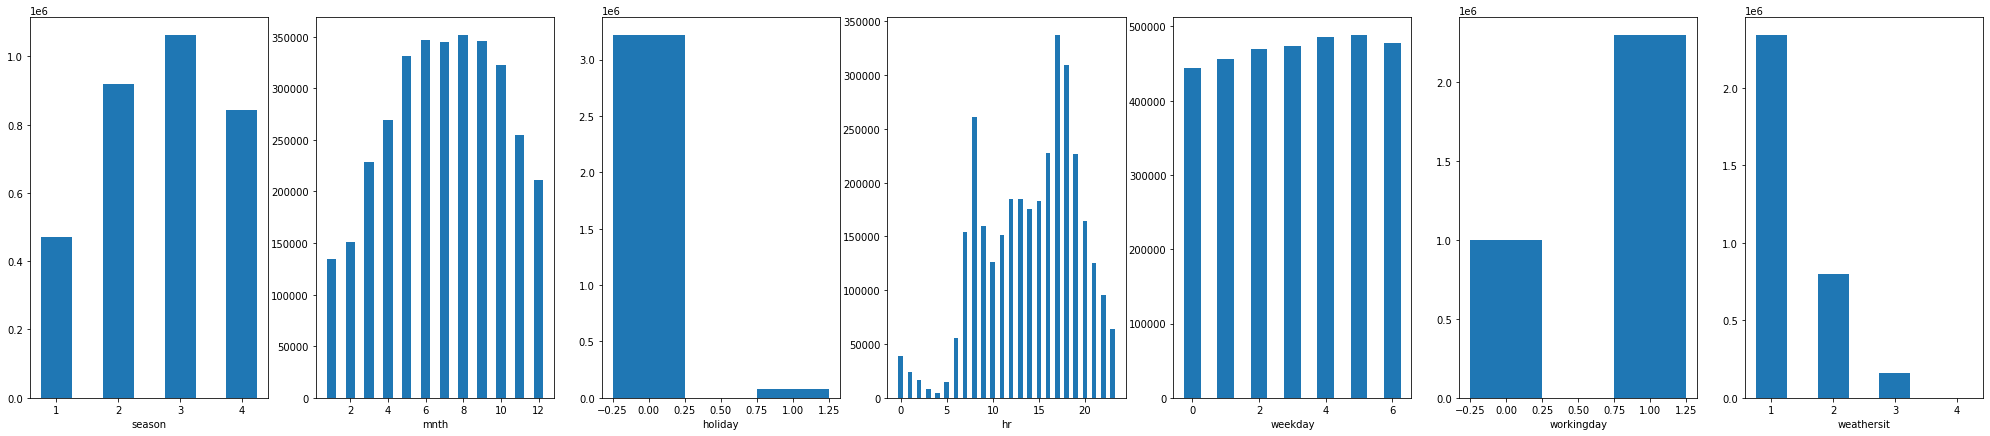

In [15]:
categorical_cols = ['season', 'mnth', 'holiday', 'hr', 'weekday', 'workingday', 'weathersit']
fig, ax = plt.subplots(1, len(categorical_cols), figsize=(35, 7))

for i in range(len(categorical_cols)):
    data = raw_data_df.groupby(categorical_cols[i]).sum()['cnt']
    x = data.index.tolist()
    y = data.tolist()
    ax[i].set_xlabel(categorical_cols[i])
    ax[i].bar(x, y, width=0.5)



- most renting hours from 8 to 10 (going to work) and 16 to 20 (returning from work)
- weathersit, most of the renting in a  (Clear, Few clouds, Partly cloudy, Partly cloudy) weather
- most of the renting are also in non holidays

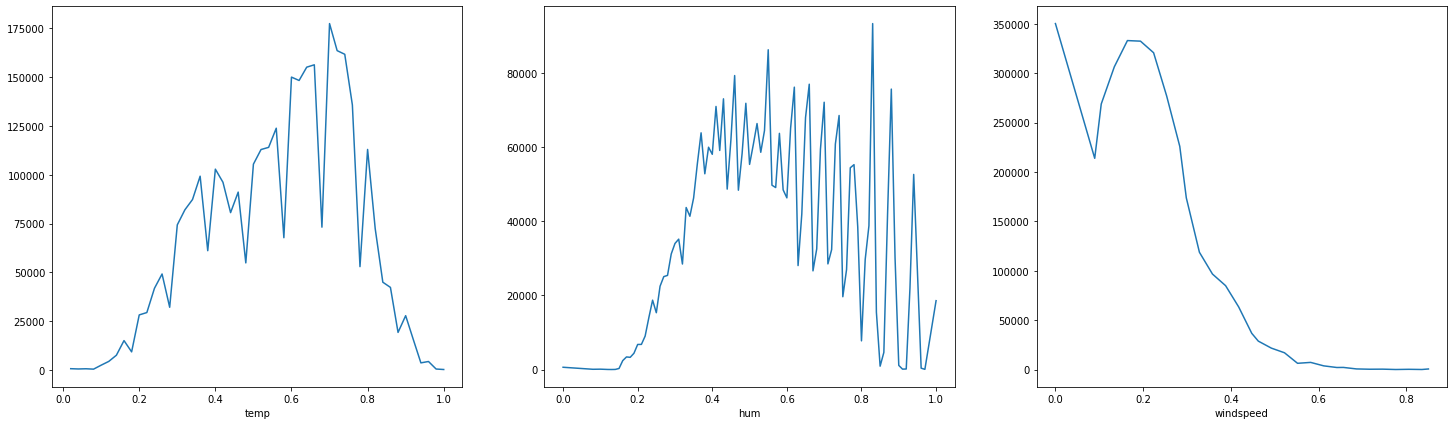

In [16]:
cont_cols = ['temp', 'hum', 'windspeed']

fig, ax = plt.subplots(1, len(cont_cols), figsize=(25, 7))

for i in range(len(cont_cols)):
    data = raw_data_df.groupby(cont_cols[i]).sum()['cnt']
    x = data.index.tolist()
    y = data.tolist()
    ax[i].set_xlabel(cont_cols[i])
    ax[i].plot(x, y)

- in the temp graph high renting count in a moderate weather not cold and not hot
- in wind speed the count of renting cycles is inversely proportional to wind speed

In [17]:

raw_data_df.corr().loc['temp', 'atemp']

0.9876721390396437

- we can select one of them as they have strong correlation almost ide

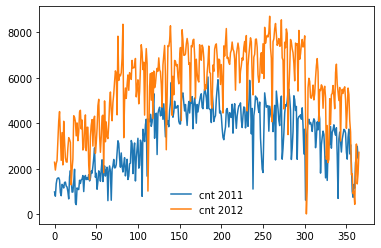

In [18]:
cnt_in_2011=raw_data_df[raw_data_df.yr==0]
cnt_in_2011=cnt_in_2011.groupby('dteday').sum()['cnt']

cnt_in_2012=raw_data_df[raw_data_df.yr==1]
cnt_in_2012=cnt_in_2012.groupby('dteday').sum()['cnt']
# cnt_in_2012=raw_data_df[raw_data_df.yr==1]['cnt']
#
plt.plot(cnt_in_2011.to_numpy(), label='cnt 2011')
plt.plot(cnt_in_2012.to_numpy(), label='cnt 2012')
#
plt.legend(frameon=False)
# cnt_in_2011

# Data preprocessing <a name=data-prep />

### fields to drop
- year field has no need in training as it was info for data collection year (0 for data collected 2011 and 1 for data collected 2012)
- registered and causal are summed into count which is the output field
- instant , index of the rows
- atemp as it has correlation with temp almost 1 we can keep temp only
- dteday --> the date of collecting the data record

### Hot Encoding
- hot encoding to categorical fields ( season , mnth , hr , holiday , weekday , workingday , weathersit )

In [19]:
raw_data_df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [20]:
preprocessed_data_df = dataset.data_preprocessing(raw_data_df)
preprocessed_data_df.head()

,temp,hum,windspeed,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,holiday_0,holiday_1,workingday_0,workingday_1,cnt
0,0.24,0.81,0.0,1,0,0,0,1,0,0,...,0,0,0,0,1,1,0,1,0,16
1,0.22,0.80,0.0,1,0,0,0,1,0,0,...,0,0,0,0,1,1,0,1,0,40
2,0.22,0.80,0.0,1,0,0,0,1,0,0,...,0,0,0,0,1,1,0,1,0,32
3,0.24,0.75,0.0,1,0,0,0,1,0,0,...,0,0,0,0,1,1,0,1,0,13
4,0.24,0.75,0.0,1,0,0,0,1,0,0,...,0,0,0,0,1,1,0,1,0,1


In [21]:
# save inputs column name to index map to a text file
with open("../dataset/preprocessed/col_idx_map.txt", 'w') as col_idx_file:
    for idx, column_name in enumerate(preprocessed_data_df.columns):
        if column_name == target_label_name:
            continue
        col_idx_file.write(f"{column_name},{idx}\n")



## Data split to test and train

In [22]:
train_data_df, test_data_df =train_test_split(preprocessed_data_df,test_size=0.25)

In [23]:
train_data_df.head()

,temp,hum,windspeed,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,holiday_0,holiday_1,workingday_0,workingday_1,cnt
7319,0.46,0.55,0.1940,0,0,0,1,1,0,0,...,0,0,0,0,0,1,0,1,0,320
8460,0.32,0.66,0.1642,1,0,0,0,0,1,0,...,0,0,0,0,1,1,0,1,0,3
7526,0.54,0.68,0.2836,0,0,0,1,1,0,0,...,1,0,0,0,0,1,0,0,1,28
9065,0.30,0.33,0.5224,1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,1,130
3261,0.58,0.64,0.0896,0,1,0,0,1,0,0,...,0,0,0,1,0,1,0,0,1,302


In [24]:
train_data_df.describe()

,temp,hum,windspeed,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,holiday_0,holiday_1,workingday_0,workingday_1,cnt
count,13034.000000,13034.000000,13034.000000,13034.000000,13034.000000,13034.000000,13034.000000,13034.000000,13034.000000,13034.000000,...,13034.000000,13034.000000,13034.000000,13034.000000,13034.000000,13034.000000,13034.000000,13034.000000,13034.000000,13034.000000
mean,0.495561,0.626589,0.190605,0.244284,0.254718,0.256099,0.244898,0.655133,0.262467,0.082323,...,0.144392,0.143778,0.141630,0.142857,0.143394,0.971689,0.028311,0.313871,0.686129,190.378011
std,0.191894,0.192294,0.122692,0.429678,0.435720,0.436494,0.430043,0.475343,0.439992,0.274867,...,0.351500,0.350878,0.348683,0.349941,0.350488,0.165865,0.165865,0.464083,0.464083,182.094321
min,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.340000,0.480000,0.104500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,41.000000
50%,0.500000,0.630000,0.194000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,142.000000
75%,0.660000,0.780000,0.253700,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,282.000000
max,0.980000,1.000000,0.850700,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,977.000000


In [25]:
test_data_df.describe()


,temp,hum,windspeed,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,holiday_0,holiday_1,workingday_0,workingday_1,cnt
count,4345.000000,4345.000000,4345.000000,4345.000000,4345.000000,4345.000000,4345.000000,4345.000000,4345.000000,4345.000000,...,4345.000000,4345.000000,4345.000000,4345.000000,4345.000000,4345.000000,4345.000000,4345.000000,4345.000000,4345.000000
mean,0.501266,0.629148,0.188576,0.243498,0.250633,0.266513,0.239356,0.661450,0.258458,0.079632,...,0.131415,0.138320,0.143843,0.143843,0.147986,0.969850,0.030150,0.327503,0.672497,186.718527
std,0.194487,0.194833,0.121279,0.429243,0.433427,0.442187,0.426739,0.473271,0.437837,0.270753,...,0.337893,0.345275,0.350971,0.350971,0.355127,0.171019,0.171019,0.469356,0.469356,179.243656
min,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.340000,0.480000,0.104500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,37.000000
50%,0.500000,0.630000,0.164200,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,141.000000
75%,0.660000,0.790000,0.253700,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,276.000000
max,1.000000,1.000000,0.656700,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,922.000000


The standard deviation and mean for the test_data and train_data are close --> good test and train split

## Save train and test preprocessed data

# Model Training <a name=model-train />

In [26]:
train_data_df.to_csv("../dataset/preprocessed/train_bike-sharing-patterns.csv", index=False)
test_data_df.to_csv("../dataset/preprocessed/test_bike-sharing-patterns.csv", index=False)

# Train and test data Loaders <a name=loaders/>

In [3]:
# col_idx_dict: dictionary with keys col_names and values the index of the column in the expected input to the model
col_idx_dict = dataset.load_col_idx_map(prep_dataset_path + '/col_idx_map.txt')
train_data_path = prep_dataset_path + '/train_bike-sharing-patterns.csv'
test_data_path = prep_dataset_path + '/test_bike-sharing-patterns.csv'

train_dataset = dataset.BikeSharingPatterns(csv_path=train_data_path, col_idx_dict=col_idx_dict,
                                            target_label=target_label_name)
test_dataset = dataset.BikeSharingPatterns(csv_path=test_data_path, col_idx_dict=col_idx_dict,
                                           target_label=target_label_name)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32)



View dataloaders

In [4]:
print("Train Loader")
train_itr = iter(train_dataloader)
data, label = next(train_itr)
print("data shape-->", data.shape, "label shape-->", label.shape)
input_size = data.shape[1]

print("Test Loader")
test_itr = iter(test_dataloader)
data, label = next(test_itr)
print("data shape-->", data.shape, "label shape-->", label.shape)

Train Loader
data shape--> torch.Size([32, 58]) label shape--> torch.Size([32, 1])
Test Loader
data shape--> torch.Size([32, 58]) label shape--> torch.Size([32, 1])


# instantiate Bike sharing prediction model

In [5]:
bike_sharing_model = model.BikeSharingModel(input_size)

# Model Architecture selection <a name=model-architecture-sel />
- select the best model architecture based on first 20 to 100 (5 min training) (epoch that will converge fast with the least overfitting
- show train and test loss curve of each architecture

___

BikeSharingModel(
  (fc1): Linear(in_features=58, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

avg time for epoch= 0m and 2s
model before training Train loss=68866.63 Test Loss=69073.95
epoch:1/137 time per epoch 1.51 Train Loss=50745.044073432946 Test Loss=31213.066340621404
epoch:2/137 time per epoch 1.49 Train Loss=27050.150491023476 Test Loss=23438.454732451093
epoch:3/137 time per epoch 1.42 Train Loss=20542.240066844406 Test Loss=17691.435514959725
epoch:4/137 time per epoch 1.21 Train Loss=16388.11426845174 Test Loss=14800.922806386652
epoch:5/137 time per epoch 1.41 Train Loss=14566.573439537939 Test Loss=13445.68748561565
epoch:6/137 time per epoch 1.24 Train Loss=13765.028608471113 Test Loss=12770.138945627157
epoch:7/137 time per epoch 1.28 Train Loss=13319.097631075456 Test Loss=12371.722596015536
epoch:8/137 time per epoch 1.3 Train Loss=12775.345065669595 Test Loss=12109.845195627158
epoch:9/137 time per epoch 1.28 Train Loss=12436.980060562759 Test Loss=11895.266380178366
epoch:10/137 time per epoch 1.67 Train Loss=12391.417642080329 Test Loss=11692.626878955696
e

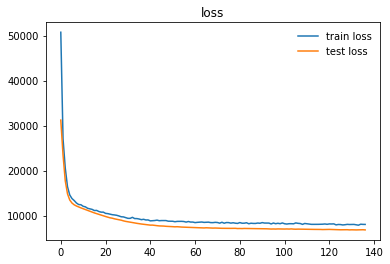

In [6]:
time_to_train=5
display(bike_sharing_model)
train_losses, test_losses =model_training.train_model(bike_sharing_model, time_to_train=5, learning_rate=0.001,
                                                         train_loader=train_dataloader, test_loader=test_dataloader)
print(f"train loss {train_losses[-1]} test loss {test_losses[-1]} in {time_to_train} m")
visualization.plot_train_validation((train_losses, "train loss"), (test_losses, "test loss"))

<p align="center"><img src="assets/m1.png" height="300"  alt="m1"/></p>>

___

BikeSharingModel(
  (fc1): Linear(in_features=58, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

avg time for epoch= 0m and 2s
model before training Train loss=68763.46 Test Loss=69062.68
epoch:1/100 time per epoch 3.55 Train Loss=44023.459078180145 Test Loss=27276.199129746834
epoch:2/100 time per epoch 2.39 Train Loss=22762.397471277043 Test Loss=18870.027294303796
epoch:3/100 time per epoch 2.47 Train Loss=16244.68048649206 Test Loss=14502.830386939011
epoch:4/100 time per epoch 2.37 Train Loss=13565.281800243594 Test Loss=12947.7671875
epoch:5/100 time per epoch 2.36 Train Loss=12527.760479802824 Test Loss=12351.142493167434
epoch:6/100 time per epoch 1.96 Train Loss=12192.781549696947 Test Loss=12037.944427862485
epoch:7/100 time per epoch 2.22 Train Loss=11862.575169388714 Test Loss=11820.347783012083
epoch:8/100 time per epoch 3.22 Train Loss=11558.486687461638 Test Loss=11685.387021720368!!!Warning Overfitting!!!

epoch:9/100 time per epoch 2.84 Train Loss=11411.31357771022 Test Loss=11385.958204473533
epoch:10/100 time per epoch 2.25 Train Loss=11187.965881300828 Test Los

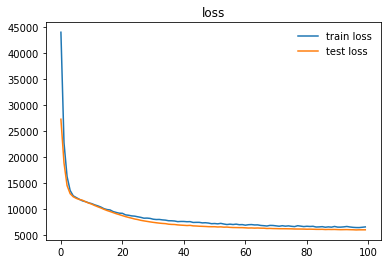

In [10]:
time_to_train=5
display(bike_sharing_model)
train_losses, test_losses =model_training.train_model(bike_sharing_model, time_to_train=5, learning_rate=0.001,
                                                         train_loader=train_dataloader, test_loader=test_dataloader)
print(f"train loss {train_losses[-1]} test loss {test_losses[-1]} in {time_to_train} m")
visualization.plot_train_validation((train_losses, "train loss"), (test_losses, "test loss"))

<p align="center"><img src="assets/m2.png" height="300"  alt="model2"/></p>>


___
seems like increasing no of neurons comes with a good result i will continue to increase until overfiting

BikeSharingModel(
  (fc1): Linear(in_features=58, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

avg time for epoch= 0m and 3.62s
model before training Train loss=68885.85 Test Loss=69085.12
epoch:1/82 time per epoch 3.04 Train Loss=39246.89560236689 Test Loss=24250.562787686995
epoch:2/82 time per epoch 2.01 Train Loss=18633.33008861439 Test Loss=15131.90818829114
epoch:3/82 time per epoch 2.04 Train Loss=13308.846444874942 Test Loss=12772.466279487917
epoch:4/82 time per epoch 2.16 Train Loss=12066.424748494323 Test Loss=12166.721743742808!!!Warning Overfitting!!!

epoch:5/82 time per epoch 2.15 Train Loss=11717.643282113127 Test Loss=11828.686340261795!!!Warning Overfitting!!!

epoch:6/82 time per epoch 2.13 Train Loss=11409.276580122181 Test Loss=11536.119480005753!!!Warning Overfitting!!!

epoch:7/82 time per epoch 2.02 Train Loss=11080.849452633496 Test Loss=11294.075920598389!!!Warning Overfitting!!!

epoch:8/82 time per epoch 2.18 Train Loss=10818.422916147192 Test Loss=10863.838417002302!!!Warning Overfitting!!!

epoch:9/82 time per epoch 2.12 Train Loss=10445.64171469809

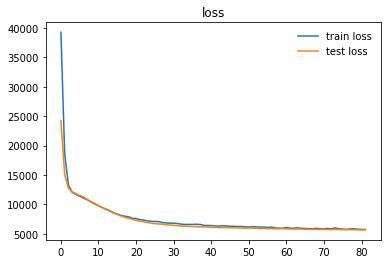

In [6]:
time_to_train=5
display(bike_sharing_model)
train_losses, test_losses =model_training.train_model(bike_sharing_model, time_to_train=5, learning_rate=0.001,
                                                         train_loader=train_dataloader, test_loader=test_dataloader)
print(f"train loss {train_losses[-1]} test loss {test_losses[-1]} in {time_to_train} m")
visualization.plot_train_validation((train_losses, "train loss"), (test_losses, "test loss"))

<p align="center"><img src="assets/m3.png" height="300"  alt="model3"/></p>>

the train loss decreased but the model starts to overfit , i will give this architecture more 5 min

avg time for epoch= 0m and 2.84s
model before training Train loss=5121.349 Test Loss=5693.500
epoch:1/105 time per epoch 2.27 Train Loss=5740.50568465168 Test Loss=5665.656053114211
epoch:2/105 time per epoch 2.57 Train Loss=5769.514446591606 Test Loss=5650.4471339182965
epoch:3/105 time per epoch 2.93 Train Loss=5744.710220325207 Test Loss=5704.801747698504
epoch:4/105 time per epoch 2.71 Train Loss=5780.239425492941 Test Loss=5660.662040599827
epoch:5/105 time per epoch 2.62 Train Loss=5725.42052546465 Test Loss=5630.284757983314
epoch:6/105 time per epoch 1.85 Train Loss=5740.451832107373 Test Loss=5621.262034306675
epoch:7/105 time per epoch 2.02 Train Loss=5782.710370773074 Test Loss=5627.932299158516
epoch:8/105 time per epoch 2.16 Train Loss=5650.469638901143 Test Loss=5645.183041750575
epoch:9/105 time per epoch 2.26 Train Loss=5791.34854155478 Test Loss=5606.133614427503
epoch:10/105 time per epoch 2.16 Train Loss=5683.313137755102 Test Loss=5601.498593929804
epoch:11/105 time

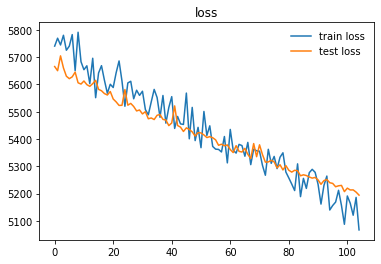

In [7]:
train_losses, test_losses =model_training.train_model(bike_sharing_model, time_to_train=5, learning_rate=0.001,
                                                         train_loader=train_dataloader, test_loader=test_dataloader)
print(f"train loss {train_losses[-1]} test loss {test_losses[-1]} in {time_to_train} m")
visualization.plot_train_validation((train_losses, "train loss"), (test_losses, "test loss"))

### Four layers
- using four layers and adding sigmoid as activation function in the mid two layers

## Final model training <a name=final-model>

BikeSharingModel(
  (fc1): Linear(in_features=58, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

avg time for epoch= 0m and 1.52s
model before training Train loss=69425.59 Test Loss=67042.14
epoch:1/1000 time per epoch 1.89 Train Loss=65306.06774589535 Test Loss=59493.44720943613
epoch:2/1000 time per epoch 1.64 Train Loss=58971.598305393585 Test Loss=53762.61116225547
epoch:3/1000 time per epoch 1.61 Train Loss=53279.69601858601 Test Loss=48717.39456271577
epoch:4/1000 time per epoch 1.6 Train Loss=48428.44506195335 Test Loss=44369.05949367089
epoch:5/1000 time per epoch 1.61 Train Loss=44492.7920462828 Test Loss=40799.21013377445
epoch:6/1000 time per epoch 1.54 Train Loss=41302.37349192496 Test Loss=37469.860795454544
epoch:7/1000 time per epoch 1.56 Train Loss=36697.57900970538 Test Loss=32376.22577675489
epoch:8/1000 time per epoch 1.65 Train Loss=32655.896379181373 Test Loss=29206.885105005753
epoch:9/1000 time per epoch 1.6 Train Loss=29757.914829724185 Test Loss=26411.449014672038
epoch:10/1000 time per epoch 1.61 Train Loss=26946.99736686263 Test Loss=24003.733731300345
e

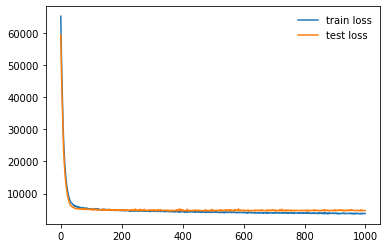

In [6]:
time_to_train=5
display(bike_sharing_model)
train_losses, test_losses =model_training.train_model(bike_sharing_model, epochs=1000, learning_rate=0.001,
                                                         train_loader=train_dataloader, test_loader=test_dataloader)
print(f"train loss {train_losses[-1]} test loss {test_losses[-1]} in {time_to_train} m")
visualization.plot_train_validation((train_losses, "train loss"), (test_losses, "test loss"))

<p align="center"><img src="assets/m4.png" height="300"  alt="model4"/></p>>

## Save final model weights <a name=save-final-w>
- load save weights before overfitting and load it into the model

In [24]:
state_dict=torch.load("../model_weights/training/04_26 03_39 Train_(4246.383 Test_(4579.406).pt")
torch.save(state_dict,"../model_weights/final/final_weights.pt")

In [25]:
state_dict=torch.load("../model_weights/final/final_weights.pt")
bike_sharing_model.load_state_dict(state_dict)

<All keys matched successfully>

## inferences

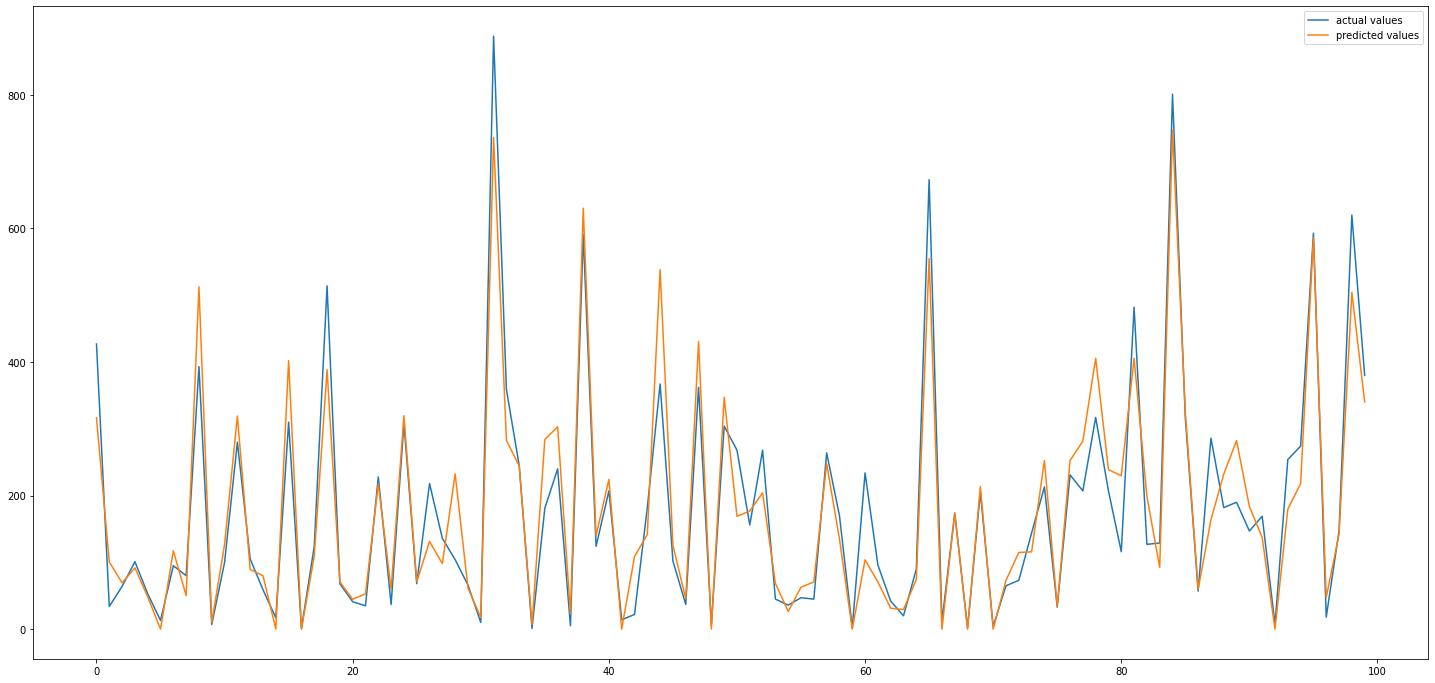

In [48]:
col_idx_dict=dataset.load_col_idx_map("../dataset/preprocessed/col_idx_map.txt")
inference_dataset=dataset.BikeSharingPatterns("../dataset/preprocessed/test_bike-sharing-patterns.csv",col_idx_dict,target_label_name)
inference_dataloader=DataLoader(inference_dataset,batch_size=1,shuffle=True)

inference_size=100


actual_values, predicted_values = np.zeros(inference_size), np.zeros(inference_size)
i = 0
bike_sharing_model.eval()
with torch.no_grad():
    for data, actual_output in inference_dataloader:

        output = bike_sharing_model.forward(data)
        output = output[0].item()

        actual_output = actual_output.view(-1).numpy()
        actual_values[i]=actual_output[0].item()

        predicted_values[i]=output
        i+=1
        if i==inference_size:
            break

bike_sharing_model.train()

fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(1, 1, 1)
ax.plot(actual_values, color='tab:blue',label="actual values")
ax.plot(predicted_values, color='tab:orange',label="predicted values")
plt.legend()